## Agent Based Models

Slightly modified and annotated code examples from Think Complexity, 2nd edition.
https://github.com/AllenDowney/ThinkComplexity2/blob/master/notebooks/chap09.ipynb
Copyright 2016 Allen Downey, MIT License http://opensource.org/licenses/MIT

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utils import decorate, savefig
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


def locs_where(condition):
    """Find cells where a logical array is True.
    
    condition: logical array
    
    returns: list of location tuples that are nonzero and fulfil the condition 
    """
    return list(zip(*np.nonzero(condition)))



# make a custom color map
palette = sns.color_palette('muted')
colors = 'white', palette[1], palette[0]
cmap = LinearSegmentedColormap.from_list('cmap', colors)
#import correlate2d from scipy signal so that neighbours can be counted
from scipy.signal import correlate2d
#use Cell2D class from Cell2D.py and also draw_array function
from Cell2D import Cell2D, draw_array

class Schelling(Cell2D):
    """Represents a grid of Schelling agents."""
    # options for correlate2d so that the boundaries wrap around when counting neighbours
    options = dict(mode='same', boundary='wrap')
    # kernel used for counting a cell's neighbours
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)
    
    def __init__(self, n, p, prob_empty):
        """Initializes the attributes.
        
        n: number of rows
        p: happiness threshold on the fraction of similar neighbors
        """
        super().__init__(n)
        self.p = p  # happiness threshold
        self.prob_emp = prob_empty    # probability of empty cells occurring
        self.prob_red = (1 - self.prob_emp)/2.0   # probability of red cells occurring
        self.prob_blue = self.prob_red  # probability of blue cells occuring
        # 0 is empty, 1 is red, 2 is blue
        choices = np.array([0, 1, 2], dtype = np.int8)
        probs = [self.prob_emp, self.prob_red , self.prob_blue]
        # use the numpy routine choice to select the different cells with probability
        self.array = np.random.choice(choices, (n, n), probs)

    def count_neighbors(self):
        """Surveys neighboring cells.
        
        returns: tuple of
            empty: True where cells are empty
            frac_red: fraction of red neighbors around each cell
            frac_blue: fraction of blue neighbors around each cell
            frac_same: fraction of neighbors with the same color
        """
        a = self.array 
        num_neighbors = np.zeros((self.n,self.n)) 
        empty = (a==0) # array with true and false for where a=0, that is empty
        red =   (a==1)
        blue =  (a==2)
        #print("empty ", empty, "red", red, "blue", blue)
        # count red neighbors, blue neighbors, and total
        num_red  = correlate2d(red, self.kernel, **self.options)
        num_blue = correlate2d(blue, self.kernel, **self.options)
        
        num_neighbors = num_red + num_blue
        #print("num_neigbours",num_neighbors)
        
        # compute fraction of similar neighbors
        
        # the next two lines replaces some code in ThinkComplexity2
        frac_red = np.where(num_neighbors>0, num_red / num_neighbors,0 )
        frac_blue = np.where(num_neighbors>0, num_blue/ num_neighbors,0 )
        #print("where num_neighbours is zero ", a[num_neighbors ==0])
       
        # for each cell, compute the fraction of neighbors with the same color
        frac_same = np.where(red, frac_red, frac_blue)
        #print("frac_red ", frac_red, "frac_blue ", frac_blue, "num_neighbors",num_neighbors )

        # compute fraction of similar neighbors
        # for empty cells, frac_same is NaN
        
        frac_same[empty] = np.nan

        return empty, frac_red, frac_blue, frac_same
        
    
    def segregation(self):
        """Computes the average fraction of similar neighbors.
        
        returns: fraction of similar neighbors, averaged over cells
        """
        _, _, _, frac_same = self.count_neighbors()
        return np.nanmean(frac_same)
    
    def step(self):
        """Executes one time step.
                
        returns: fraction of similar neighbors, averaged over cells
        """
        a = self.array
        empty, _, _, frac_same = self.count_neighbors()
        
        # find the unhappy cells (ignore NaN in frac_same)
        with np.errstate(invalid='ignore'):
            unhappy = frac_same < self.p
        
        unhappy_locs = locs_where(unhappy)
        #print("unhappy locs", unhappy_locs)
        
        # find the empty cells
        empty_locs = locs_where(empty)
       
        #print("empty locs ", empty_locs)

        # shuffle the unhappy cells
        if len(unhappy_locs):
            np.random.shuffle(unhappy_locs)
        
        # for each unhappy cell, choose a random destination
        num_empty = np.sum(empty) # find out how many empty cells there are
        
        for source in unhappy_locs:
            i = np.random.randint(num_empty) # random number chosen from empty cell list
            # here a random empty cell is chosen as a destination without considering if  happiness will be improved
            dest = empty_locs[i]
            
            # move
            a[dest] = a[source] # destination cell will be red if source red and blue if source is blue
            a[source] = 0       # source cell set to empty
            empty_locs[i] = source  # source cell added to list of empty cells
        
            # check that the number of empty cells is unchanged
            num_empty2 = np.sum(a==0)
            assert num_empty == num_empty2
        
        # return the average fraction of similar neighbors
        return np.nanmean(frac_same)  
        
    def draw(self):
        """Draws the cells."""
        return draw_array(self.array, cmap=cmap, vmax=2)
    



0.4238095238095238

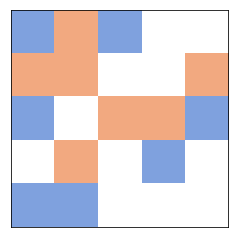

In [2]:
grid = Schelling(5, 0.3, 0.4)
grid.draw()
grid.segregation()

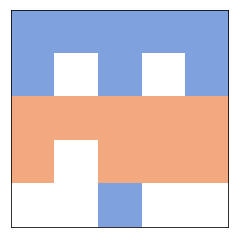

In [3]:
grid = Schelling(5, 0.5, 0.4)
grid.animate(frames=30, interval=0.1)

C:\Users\heath\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
C:\Users\heath\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide


Saving figure to file schelling


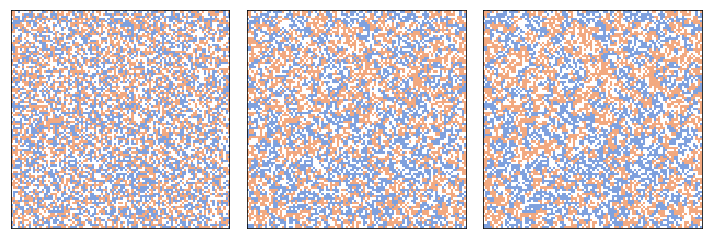

In [4]:
from utils import three_frame

grid = Schelling(100, 0.3,0.4)
three_frame(grid, [0, 2, 8])

savefig('schelling')

C:\Users\heath\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
C:\Users\heath\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide


0.5 0.8827515991471216 0.38275159914712165
0.4 0.8295283191702248 0.4295283191702248
0.3 0.7445305260435748 0.44453052604357485
0.2 0.6023078005205036 0.4023078005205036
Saving figure to file schelling_p


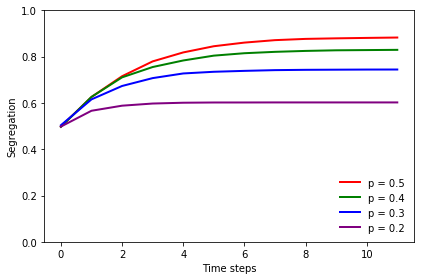

In [5]:
from utils import set_palette
set_palette('Blues', 5, reverse=True)
colours = ['r','g','b','purple','yellow'] 
colour_pos = 0;
np.random.seed(16) # a seed number for the pseudo-random number generator. 
# Useful to product the same random sequence when testing

for p in [0.5, 0.4, 0.3, 0.2]:
    grid = Schelling(100, p, 0.4)
    segs = [grid.step() for i in range(12)]
    plt.plot(segs, label='p = %.1f' % p,color = colours[colour_pos] )
    print(p, segs[-1], segs[-1] - p)
    colour_pos = colour_pos + 1
    
decorate(xlabel='Time steps', ylabel='Segregation',
                loc='lower right', ylim=[0, 1])

savefig('schelling_p')